<a href="https://colab.research.google.com/github/luisfrancs/resting_tremor_detection/blob/main/2025_Tremor_detection_Example_Turin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RESTING TREMOR DETECTION USING SMARTWATCH ACCELEROMETERS AND MACHINE/DEEP LEARNING
## 01HXDIU - Machine Learning in Healthcare: From Theory to Practice
### Author: Phd Luis Sigcha
### Date: 19/05/2025


### IMPORT LIBRARIES

In [ ]:
import os
import urllib.request
import numpy as np
import pandas as pd
import itertools
import scipy.io
from scipy import signal
from scipy.stats import iqr,entropy
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
from numpy import where
import sklearn
from sklearn.metrics import confusion_matrix, auc,roc_curve, auc, precision_recall_curve,f1_score,balanced_accuracy_score
import seaborn as sns
from numpy import argmax
from scipy.fft import fft

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Input,Flatten,Dropout,MaxPooling1D,GlobalAveragePooling1D,InputLayer,GaussianNoise
from tensorflow.keras import initializers
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## DOWNLOAD DATA FROM ZENODO REPOSITORY

In [ ]:
# Check if the file exists
if not os.path.exists("MONIPAR_PD_SUPERVISED.mat"):
    print("Database not found. Downloading...")
    # prompt: download data from zenodo
    !wget https://zenodo.org/records/8104853/files/MONIPAR_PD_REMOTE.mat
    !wget https://zenodo.org/records/8104853/files/MONIPAR_PD_REMOTE_TREMOR_LABEL.mat
    !wget https://zenodo.org/records/8104853/files/MONIPAR_PD_SUPERVISED.mat
    !wget https://zenodo.org/records/8104853/files/MONIPAR_PD_SUPERVISED_TREMOR_LABEL.mat
    print("Download complete.")
else:
    print("Database already exists.")

Database not found. Downloading...
--2025-05-19 13:29:06--  https://zenodo.org/records/8104853/files/MONIPAR_PD_REMOTE.mat
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14960473 (14M) [application/octet-stream]
Saving to: ‘MONIPAR_PD_REMOTE.mat’

MONIPAR_PD_REMOTE.m 100%[===================>]  14.27M  2.10MB/s    in 9.0s    

2025-05-19 13:29:15 (1.58 MB/s) - ‘MONIPAR_PD_REMOTE.mat’ saved [14960473/14960473]

--2025-05-19 13:29:15--  https://zenodo.org/records/8104853/files/MONIPAR_PD_REMOTE_TREMOR_LABEL.mat
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21348 (21K) [application/octet-stream]
Saving to: ‘MONIPAR_PD_REMOTE_TREMOR_LABEL.mat’

MONIPAR_PD_REMOTE_

## USEFUL FUCTIONS

In [ ]:
'''Load data'''
def load_full_data(windowsize=64):
    X_sup,y_sup,idLOSO_sup=load_data_and_preProces_supervised(windowsize=windowsize)
    X_rem,y_rem,idLOSO_rem=load_data_and_preProces_remote(windowsize=windowsize)
    X=np.concatenate((X_sup, X_rem), axis=0)
    y=np.concatenate((y_sup, y_rem), axis=0)
    idLOSO_rem=idLOSO_rem+6#add a six to diferenciate of the previous dataset
    idLOSO=np.concatenate((idLOSO_sup, idLOSO_rem), axis=0)
    y=np.round(y)
    return X,y,idLOSO

def load_data_and_preProces_remote(windowsize=64):
    dataCells = load_data_Cells(fileName = 'MONIPAR_PD_REMOTE.mat')
    labelCells = load_label_Cells(fileName = 'MONIPAR_PD_REMOTE_TREMOR_LABEL.mat')
    X,y,idLOSO = data_preparation(dataCells, labelCells,
                                           sensitivity=9.8, windowsize=windowsize, overlap=overlap)
    return X,y,idLOSO

def load_data_and_preProces_supervised(windowsize=64):
    dataCells = load_data_Cells(fileName = 'MONIPAR_PD_SUPERVISED.mat')
    labelCells = load_label_Cells(fileName = 'MONIPAR_PD_SUPERVISED_TREMOR_LABEL.mat')
    X,y,idLOSO = data_preparation(dataCells, labelCells,
                                           sensitivity=9.8, windowsize=windowsize, overlap=overlap)
    return X,y,idLOSO

def load_data_Cells(fileName):
    if fileName == 'MONIPAR_PD_REMOTE.mat':
        RAWDATA = "REMOTE_RAWDATA"
    elif fileName == 'MONIPAR_PD_SUPERVISED.mat':
        RAWDATA = "SUPERVISED_RAWDATA"
    else:
        print('No Database selected')
    mat = scipy.io.loadmat(fileName)#load matlab file
    dataCells = mat[RAWDATA]
    print(RAWDATA, " loaded")
    print('Number of cells (subjects, weeks)',dataCells.shape)
    return (dataCells)

def load_label_Cells(fileName):
    if fileName == 'MONIPAR_PD_REMOTE_TREMOR_LABEL.mat':
        RAWDATA = "REMOTE_TREMOR_LABEL"
    elif fileName == 'MONIPAR_PD_SUPERVISED_TREMOR_LABEL.mat':
        RAWDATA = "SUPERVISED_TREMOR_LABEL"
    else:
        print('No Database selected')
    mat = scipy.io.loadmat(fileName)#load matlab file
    dataCells = mat[RAWDATA]
    print(RAWDATA, " loaded")
    print('Number of cells (subjects, weeks)',dataCells.shape)
    return (dataCells)

def data_preparation(dataCells,labelCells,sensitivity, windowsize,overlap):
    cells_shape=dataCells.shape
    number_subjects=cells_shape[0]
    number_weeks=cells_shape[1]
    X,y,idLOSO = np.empty([1,windowsize,3]),np.empty([1,1]),np.empty([1,1])
    for i in range(number_subjects):
      for j in range(number_weeks):
        #print("Subject",i,"week",j )
        try:
          'Split data in windows'
          raws=signal_Split_rawFile_triaxial(dataCells[i][j],sensitivity=sensitivity, windowsize=windowsize,overlap=overlap)#EXTRACT RAW SIGNAL
          label=split_Label_rawFile(labelCells[i][j],data_column=0,windowsize=windowsize,overlap=overlap)#LABEL EXTRACTION
          idx=i*np.ones((label.shape))#SUBJECT ID
          'Concat'
          X=np.concatenate((X, raws), axis=0)
          y=np.concatenate((y, label), axis=0)
          idLOSO=np.concatenate((idLOSO, idx), axis=0)
          #features=np.concatenate((features, feats), axis=0)
        except:
          print("no extraction in the cell i:", i," j:" ,j)
    return X,y,idLOSO#,features

In [ ]:
def buffer(X, n, p=0, opt=None):
    '''Mimic MATLAB routine to generate buffer array
    X: ndarray         Signal array
    n: int         window size in samples
    p: int         Number of values to overlap
    opt: str         Initial condition options. default sets the first `p` values to zero, while 'nodelay' begins filling the buffer immediately.'''
    if opt not in [None, 'nodelay']:
        raise ValueError('{} not implemented'.format(opt))
    i = 0
    first_iter = True
    while i < len(X):
        if first_iter:
            if opt == 'nodelay':
                result = X[:n]
                i = n
            else:
                result = np.hstack([np.zeros(p), X[:n-p]])
                i = n-p
            result = np.expand_dims(result, axis=0).T
            first_iter = False
            continue
        col = X[i:i+(n-p)]
        if p != 0:
            col = np.hstack([result[:,-1][-p:], col])
        i += n-p
        if len(col) < n:
            col = np.hstack([col, np.zeros(n-len(col))])
        result = np.hstack([result, np.expand_dims(col, axis=0).T])
    return result

def printLabel_distribution(y):
    df=pd.DataFrame(y)
    count_classes = pd.value_counts(df[0], sort = True)
    count_classes.plot(kind = 'bar', rot=0)
    plt.title("Class distribution")
    plt.xlabel("Class")
    plt.ylabel("Frequency")

'''Training-validation-test spliting'''
def train_val_test(id):
    ''' Subject subsets '''
    trainPd= [0,20,4,7,10,13,16,9,14,12,19]
    valPd = [1,6,17]
    testPd =  [2,3,5,8,11,15,18,]
    print("Number of sujects in TRAIN: ", len(np.unique(trainPd)))
    print("Number of sujects in VAL: ", len(np.unique(valPd)))
    print("Number of sujects in TEST: ", len(np.unique(testPd)))
    trainInd,valInd,testInd = [],[],[]
    for pd in trainPd:
        ind = where(id == pd)
        trainInd.append(ind[0])
    trainInd = np.concatenate(trainInd,axis=0)
    for pd in valPd:
        ind = where(id == pd)
        valInd.append(ind[0])
    valInd = np.concatenate(valInd,axis=0)
    for pd in testPd:
        ind = where(id == pd)
        testInd.append(ind[0])
    testInd = np.concatenate(testInd,axis=0)
    return trainInd,valInd,testInd


In [ ]:
'''Data Windowing'''

def signal_Split_rawFile(single_file,data_column=0,sensitivity=1, windowsize=64,overlap=0):
    '''TO BE USED with CNN'''
    data_column=single_file[:,data_column]#select only data column
    data_column=data_column/sensitivity#normalize data
    m_buffer=buffer(data_column, n=windowsize, p=overlap, opt='nodelay')#buffer data (aka split dat in windows)
    m_buffer=m_buffer.T#transpose
    return m_buffer

def signal_Split_rawFile_triaxial(single_file,sensitivity=1, windowsize=64,overlap=0):
    #print("single_file_shape: ",single_file.shape)
    '''TO BE USED with CNN'''
    x=signal_Split_rawFile(single_file,data_column=1,sensitivity=sensitivity, windowsize=windowsize,overlap=overlap)
    y=signal_Split_rawFile(single_file,data_column=2,sensitivity=sensitivity, windowsize=windowsize,overlap=overlap)
    z=signal_Split_rawFile(single_file,data_column=3,sensitivity=sensitivity, windowsize=windowsize,overlap=overlap)
    raw_triaxial = np.stack((x, y, z),axis=2)#create a 3D array
    return raw_triaxial

def split_Label_rawFile(single_file,data_column=2, windowsize=1250,overlap=0):
    data_column=single_file[:,data_column]#select only data column
    m_buffer=buffer(data_column, n=windowsize, p=overlap, opt='nodelay')#buffer data (aka split dat in windows)
    m_buffer=m_buffer.T#transpose
    label=np.apply_along_axis(label_logic, 1, m_buffer)#extract feature matrix
    label=np.round(label)
    label = np.expand_dims(label, axis=1)
    return label

def label_logic(a):
    if np.all(a == 2):
        result=2
    elif np.all(a == 1):
        result=1
    elif np.all(a == 0):
        result=0
    else:
        result=-1#-1 labeled for exlusion
    return result


## LOAD DATA

In [ ]:
'''Set variables'''
fs=50 #databse sample rate
windowsize=128# expresed in samples
overlap=64;# expresed in samples
print("Sampling rate: ",fs)

Sampling rate:  50


In [ ]:
'''Load Data and preprocess'''
X, y,idLOSO=load_full_data(windowsize=windowsize)

SUPERVISED_RAWDATA  loaded
Number of cells (subjects, weeks) (6, 8)
SUPERVISED_TREMOR_LABEL  loaded
Number of cells (subjects, weeks) (6, 8)
no extraction in the cell i: 2  j: 6
no extraction in the cell i: 2  j: 7
REMOTE_RAWDATA  loaded
Number of cells (subjects, weeks) (15, 8)
REMOTE_TREMOR_LABEL  loaded
Number of cells (subjects, weeks) (15, 8)
no extraction in the cell i: 0  j: 5
no extraction in the cell i: 0  j: 6
no extraction in the cell i: 0  j: 7
no extraction in the cell i: 1  j: 6
no extraction in the cell i: 1  j: 7
no extraction in the cell i: 2  j: 6
no extraction in the cell i: 2  j: 7
no extraction in the cell i: 3  j: 0
no extraction in the cell i: 3  j: 1
no extraction in the cell i: 3  j: 2
no extraction in the cell i: 3  j: 3
no extraction in the cell i: 3  j: 4
no extraction in the cell i: 3  j: 5
no extraction in the cell i: 3  j: 6
no extraction in the cell i: 3  j: 7
no extraction in the cell i: 4  j: 0
no extraction in the cell i: 4  j: 4
no extraction in the 

Label:  [2.]


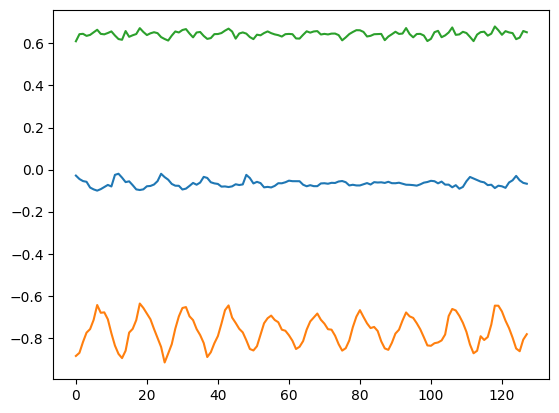

In [ ]:
'''TASK 1: Plot a single observation of tremor (label=1) and non-tremor (label=0)'''
#Consider using: plt.plot

observation=10000
print("Label: ", y[observation])
plt.plot(X[observation])

In [ ]:
X.shape

(13035, 128, 3)

<ipython-input-4-fe7c56802e6d>:33: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df[0], sort = True)


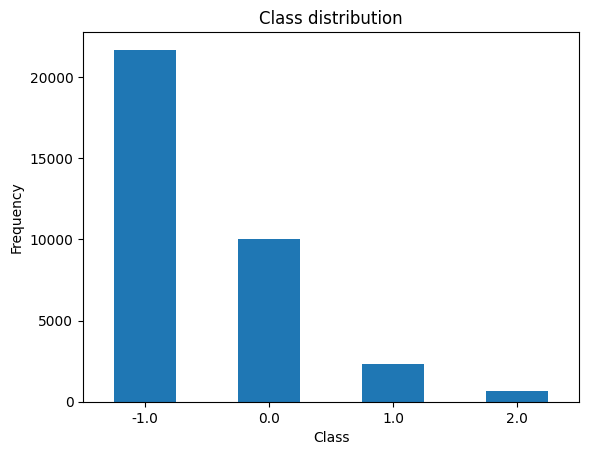

In [ ]:
'''Plot tremor label distrution'''
printLabel_distribution(y)

In [ ]:
#LABEL AJUST
y = np.where(y ==2, 1, y)#change tremor label 2 to 1

<ipython-input-4-fe7c56802e6d>:33: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df[0], sort = True)


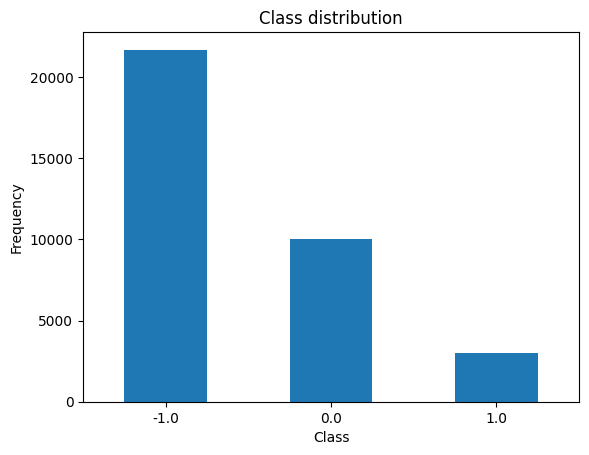

In [ ]:
printLabel_distribution(y)

### REMOVE UNNECESARY DATA

In [ ]:
'''REMOVE UNNECESARY DATA'''
def valid_data(valid_data):
    mask = (valid_data >= 0) #Selects all but <-1
    return mask

def select_valid_data(X,y,idx,target):
    valid_mask=valid_data(target)#
    print(valid_mask.shape)
    X_nu=X[valid_mask,:,:]#
    y_nu=y[valid_mask,:] #
    idx_nu=idx[valid_mask,:]
    return X_nu,y_nu,idx_nu

In [ ]:
"""SELECT VALID DATA"""
X,y,idLOSO = select_valid_data(X,y,idLOSO,y[:,0])#eliminates labels with -1 in TREMOR (y[:,1]) #-1 means movement
print(X.shape)

(34715,)
(13035, 128, 3)


<ipython-input-4-fe7c56802e6d>:33: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df[0], sort = True)


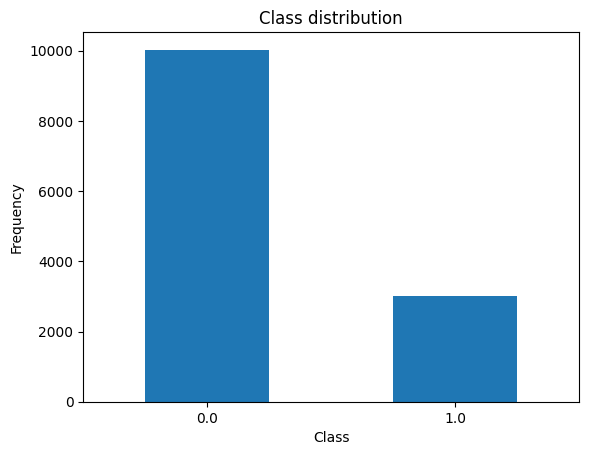

In [ ]:
printLabel_distribution(np.round(y))

### OPTIONAL PROCESSING VIA FFT

In [ ]:
def fft_on_triaxis(data):
    fft_result = np.fft.fft(data, axis=1)# Perform FFT along the second dimension (axis=1)
    magnitude = np.abs(fft_result)# Calculate the magnitude of the FFT
    n = data.shape[1]  # number of samples (n) in the FFT
    magnitude /= n# Normalize the amplitude by the number of samples (n)
    fft_result_single_side = fft_result[:, :n//2+1, :]# Only keep the first half (positive frequencies)
    magnitude_single_side = magnitude[:, :n//2+1, :]# Adjust the magnitude for the single-side spectrum
    magnitude_single_side[:, 1:-1, :] *= 2  # Scale the magnitudes: Multiply by 2, except for the DC and Nyquist components
    magnitude_single_side = np.nan_to_num(magnitude_single_side)
    return magnitude_single_side

In [ ]:
#TRANSFORM DATA BY APPLYING FFT
X=fft_on_triaxis(X)
# Replace nan with 0
X = np.nan_to_num(X, nan=0.0)

### OPTIONAL RANDOM OVERSAMPLING THE MINORITY CLASS

In [ ]:
"""RANDOM OVERSAMPLING"""
def over_sampling(train_features, train_labels,idx):
    print(train_labels.shape)
    bool_train_labels=(idx == 1)#changed to select tremor label
    pos_features,neg_features= train_features[bool_train_labels,:],train_features[~bool_train_labels,:]
    pos_labels,neg_labels = train_labels[bool_train_labels],train_labels[~bool_train_labels]
    pos_id, neg_id  = idx[bool_train_labels],idx[~bool_train_labels]
    ids = np.arange(len(pos_features))
    choices = np.random.choice(ids, len(neg_features))
    res_pos_features = pos_features[choices]
    res_pos_labels = pos_labels[choices]
    res_pos_id = pos_id[choices]
    resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
    resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)
    resampled_id = np.concatenate([res_pos_id, neg_id], axis=0)
    order = np.arange(len(resampled_labels))
    np.random.shuffle(order)
    resampled_features = resampled_features[order]
    resampled_labels = resampled_labels[order]
    resampled_id = resampled_id[order]
    unique, counts = np.unique(resampled_labels, return_counts=True)#changed to select tremor label
    print('Oversampled distribution:')
    print(np.asarray((unique, counts)).T)
    return resampled_features,resampled_labels,resampled_id

### HOLD OUT DATA SPLITTING

In [ ]:
'''Define training, validation, and test data'''
#MANUAL SPLIT DATA (HOLD OUT)
trainInd,valInd,testInd = train_val_test(idLOSO)
X_train, y_train = X[trainInd,:], y[trainInd,:]
X_val, y_val = X[valInd,:], y[valInd,:]
X_test, y_test = X[testInd,:], y[testInd,:]

Number of sujects in TRAIN:  11
Number of sujects in VAL:  3
Number of sujects in TEST:  7


<ipython-input-4-fe7c56802e6d>:33: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df[0], sort = True)


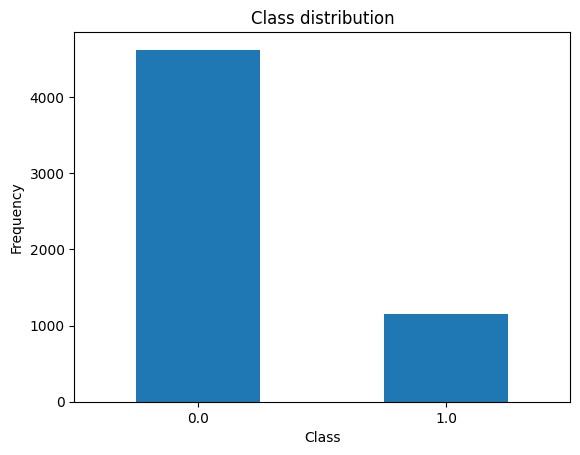

In [ ]:
printLabel_distribution(y_train)

<ipython-input-4-fe7c56802e6d>:33: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df[0], sort = True)


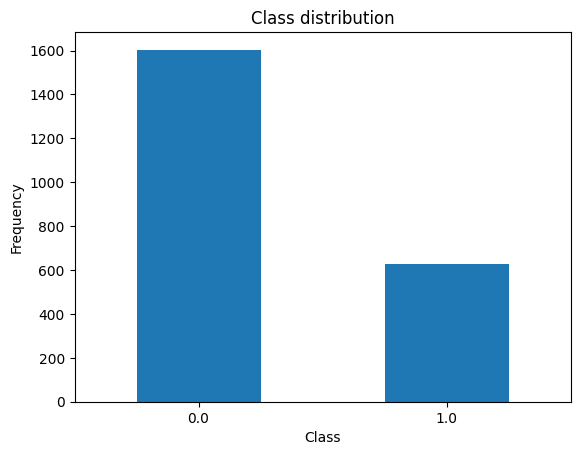

In [ ]:
printLabel_distribution(y_val)

<ipython-input-4-fe7c56802e6d>:33: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df[0], sort = True)


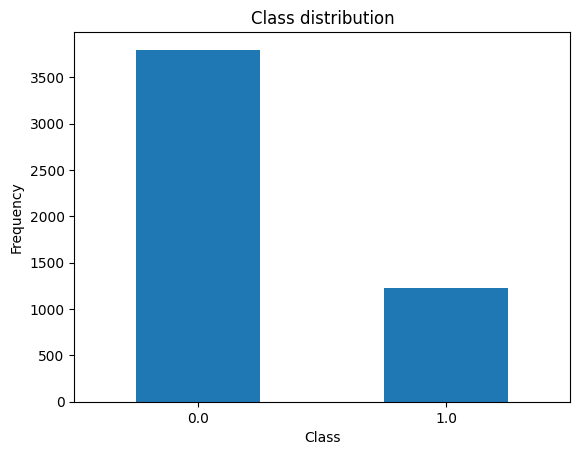

In [ ]:
printLabel_distribution(y_test)

In [ ]:
#RANDOM OVERSAMPLING ON TEST
X_train_OV,y_train_OV,_= over_sampling(train_features=X_train, train_labels=y_train,idx=y_train[:,0])

(5781, 1)
Oversampled distribution:
[[0.000e+00 4.623e+03]
 [1.000e+00 4.623e+03]]


<ipython-input-4-fe7c56802e6d>:33: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df[0], sort = True)


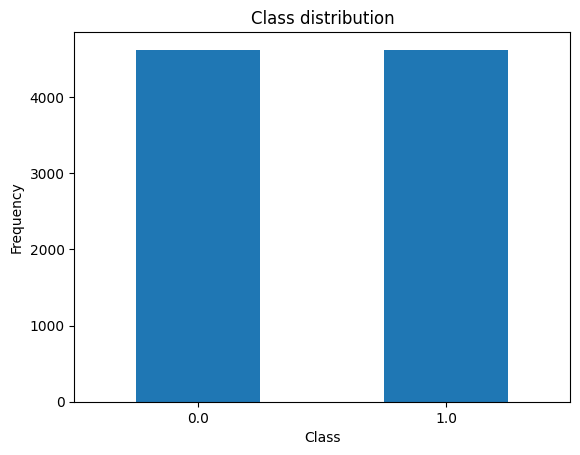

In [ ]:
printLabel_distribution(y_train_OV)

## DEEP LEARNING CLASSIFICATION

### CNN MODEL

In [ ]:
from keras.layers import BatchNormalization

In [ ]:
def get_Bikias_model(output_bias,window_length=64, cnn_dp=0.4,gap_dp=0.5,num_classes=1,model_nblocks=1):
    #Modelo convolucional BIKIAS RAW
    model = Sequential()
    for _ in range(model_nblocks):
        model.add(Conv1D (filters = 100, kernel_size = (10),input_shape = (window_length,3), activation='relu'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Dropout(cnn_dp))
        model.add(MaxPooling1D(pool_size=3, strides=None))
    model.add(Conv1D (filters = 40, kernel_size = (10), activation='relu'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(gap_dp))
    model.add(Dense(num_classes, activation='sigmoid',bias_initializer=output_bias))
    model.summary()
    return model

In [ ]:
### TRAINING MODEL FUNCTION
def trainModel(X_train, y_train,X_val,y_val,learningRate, windowSize, batchSize,nEpochs):
    '''Train the model'''
    #Initial Bias
    unique, counts = np.unique(y_train[:,0], return_counts=True)
    print("Count Train")
    print(np.asarray((unique, counts)).T)
    pos,neg=counts[1],counts[0]
    initial_bias = np.log([pos/neg])
    print('initial_bias: ', initial_bias)
    output_bias = tf.keras.initializers.Constant(initial_bias)
    #Class weigth
    total=pos+neg
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    #Optimizer
    optimizer = optimizers.Adam(learning_rate=learningRate, beta_1=0.9,beta_2=0.999, epsilon=1e-08, clipvalue=1.)
    model= get_Bikias_model(output_bias,window_length=windowSize, cnn_dp=0.4,gap_dp=0.5,num_classes=1,model_nblocks=1)
    pr_metric = AUC(name='prc',curve='PR', num_thresholds=100)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = [pr_metric], weighted_metrics=["accuracy"],)
    stop_early=EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=3, verbose=0, mode='auto',restore_best_weights=True) #default patience=8
    history = model.fit(X_train,y_train, epochs=nEpochs, batch_size=batchSize, validation_data=(X_val,y_val), callbacks=[stop_early], verbose=1,
                        #class_weight=class_weight # Class weights <====
                        )
    model_evaluation_val = model.evaluate(X_val, y_val, verbose=0)
    model_evaluation_test = model.evaluate(X_test, y_test, verbose=0)

    model.summary()
    return model, model_evaluation_val,model_evaluation_test, history


### TRAINING PREFERENCES

In [ ]:
window_length=X_train.shape[1]
nEpochs = 100
batchSize = 16
learningRate= 0.0000123#
model, model_evaluation_val,model_evaluation_test,history = trainModel(X_train, y_train,X_val,y_val,learningRate, window_length, batchSize,nEpochs)
#model, model_evaluation_val,model_evaluation_test,history = trainModel(X_train_OV,y_train_OV,X_val,y_val,learningRate, window_length, batchSize,nEpochs)

print(f'METRICS_validation : {model_evaluation_val}, batch : {batchSize}, learning rate : {learningRate}')
print(f'METRICS_tests : {model_evaluation_test}, batch : {batchSize}, learning rate : {learningRate}')

Count Train
[[0.000e+00 4.623e+03]
 [1.000e+00 1.158e+03]]
initial_bias:  [-1.38434947]
Weight for class 0: 0.63
Weight for class 1: 2.50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 56, 100)             │           3,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 18, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 9, 40)               │          40,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 9, 40)               │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9, 40)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 40)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,741 (170.86 KB)

 Trainable params: 43,461 (169.77 KB)

 Non-trainable params: 280 (1.09 KB)

Epoch 1/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7950 - loss: 0.4930 - prc: 0.3047 - val_accuracy: 0.7212 - val_loss: 0.5747 - val_prc: 0.8362
Epoch 2/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8354 - loss: 0.4006 - prc: 0.5960 - val_accuracy: 0.8252 - val_loss: 0.3868 - val_prc: 0.8680
Epoch 3/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8674 - loss: 0.3374 - prc: 0.7273 - val_accuracy: 0.8530 - val_loss: 0.3458 - val_prc: 0.8689
Epoch 4/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8803 - loss: 0.3140 - prc: 0.7469 - val_accuracy: 0.8548 - val_loss: 0.3506 - val_prc: 0.8725
Epoch 5/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8837 - loss: 0.3100 - prc: 0.7448 - val_accuracy: 0.8597 - val_loss: 0.3279 - val_prc: 0.8738
Epoch 6/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8776 - loss: 0.3218 - prc: 0.7219 - val_accuracy: 0.8557 - val_loss: 0.3585 - val_prc: 0.8784
Epoch 7/100
362/362 ━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 56, 100)             │           3,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 18, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 9, 40)               │          40,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 9, 40)               │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9, 40)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 40)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,665 (510.41 KB)

 Trainable params: 43,461 (169.77 KB)

 Non-trainable params: 280 (1.09 KB)

 Optimizer params: 86,924 (339.55 KB)

METRICS_validation : [0.27916595339775085, 0.9053910970687866, 0.8709099292755127], batch : 16, learning rate : 1.23e-05
METRICS_tests : [0.2739485800266266, 0.8816836476325989, 0.8785344362258911], batch : 16, learning rate : 1.23e-05


In [ ]:
'''TASK 2: Try different training settings'''
#Suggestion: reduce the batch size
#Reduce the learning rate
#Increase or reduce the window length on data loading
#User an oversampled train subset

'TASK 2: Try different training settings'

## TRAINING EVALUATION

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.05,1])
    plt.ylim([0,1.05])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

def plot_metrics(history):
    metrics = ['loss', 'prc','accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0,1])
        else:
            plt.ylim([0,1])
        plt.legend();

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

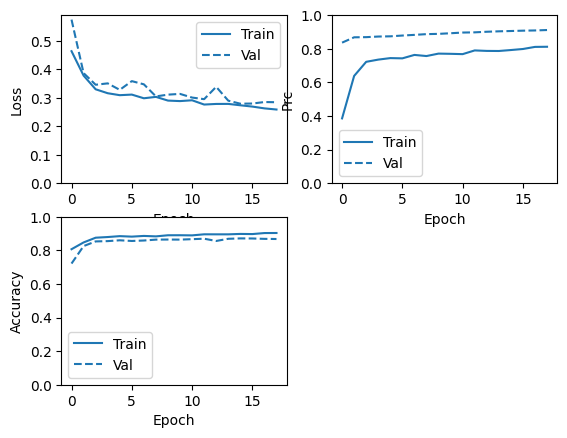

In [ ]:
plot_metrics(history)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


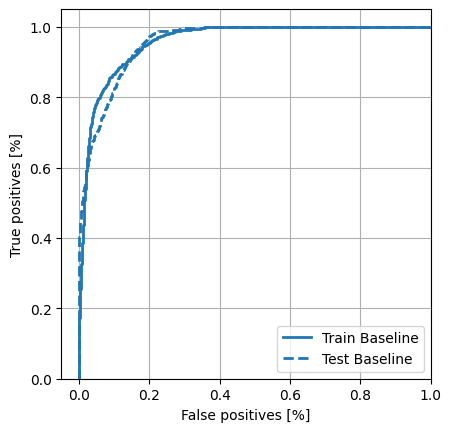

In [ ]:
train_predictions_baseline = model.predict(X_train, batch_size=1024)
test_predictions_baseline = model.predict(X_test, batch_size=1024)
plot_roc("Train Baseline", y_train, train_predictions_baseline)
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

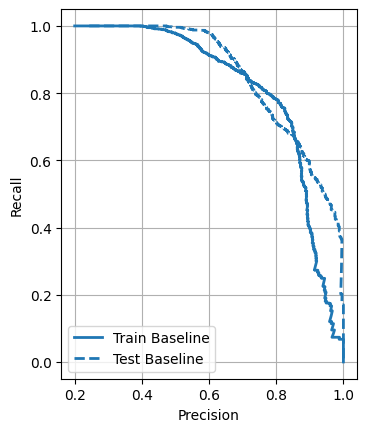

In [ ]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower left');

## TRESHOLD SELECTION AND FINE TUNING

True Negatives:  3727
False Positives:  72
False Negatives:  538
True Positives:  685


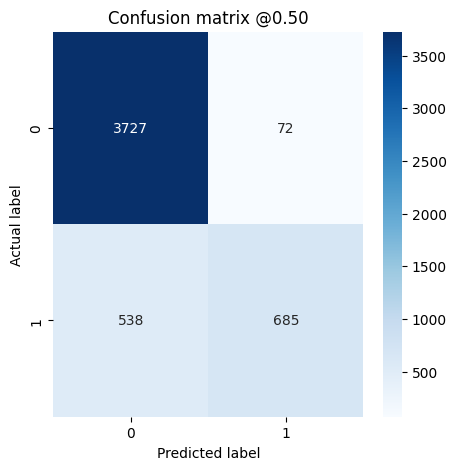

In [ ]:
plot_cm(y_test, test_predictions_baseline, p=0.5)

### Discuss: What about the results?

## THRESHOLD SELECTION

In [ ]:
def prcThreshold(labels, predictions):
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, predictions)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = argmax(fscore)
    print('Best prcThreshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    return thresholds[ix]

def eerThreshold(labels, y_predict_prob):
    fpr, tpr, thresholds = roc_curve(labels, y_predict_prob)
    roc_auc = auc(fpr, tpr)
    fnr = 1 - tpr
    EER = 100*fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
    print('Best EER Threshold=%f, Roc_AUC=%.3f'  % (eer_threshold, roc_auc) )
    return eer_threshold

In [ ]:
prc_Threshold=prcThreshold(y_train, train_predictions_baseline)
eer_Threshold=eerThreshold(y_train, train_predictions_baseline)

Best prcThreshold=0.296849, F-Score=0.792
Best EER Threshold=0.162382, Roc_AUC=0.959


True Negatives:  3675
False Positives:  124
False Negatives:  427
True Positives:  796


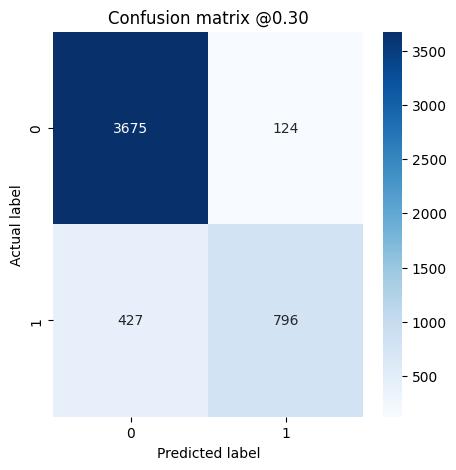

In [ ]:
plot_cm(y_test, test_predictions_baseline, p=prc_Threshold)

True Negatives:  3515
False Positives:  284
False Negatives:  290
True Positives:  933


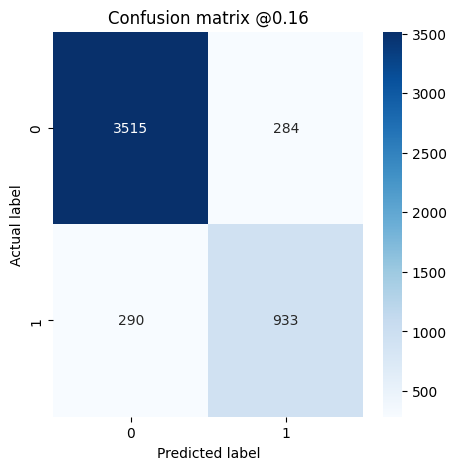

In [ ]:
plot_cm(y_test, test_predictions_baseline, p=eer_Threshold)

## CLASSIC MACHINE LEARNING CLASSIFICATION

#### Discuss the pipeline and data shape

### Feature Extraction

In [ ]:
def feature_extractor(a):
    mean1=np.mean(a,axis=0)
    std2=np.std(a,axis=0)
    median2=np.median(a,axis=0)
    maxval=np.amax(a,axis=0)
    minval=np.amin(a,axis=0)
    powerRMS = (np.sqrt(np.mean(a**2)))**2
    interquartilrange=iqr(a, axis=0)
    entropy_value = entropy(a, base=2)
    burg=sm.regression.linear_model.burg(a, order=4)
    Auto_Regre_coeff=burg[0]
    result=[mean1,std2,median2,maxval,minval,powerRMS,interquartilrange,entropy_value,(-1*Auto_Regre_coeff[0]),(-1*Auto_Regre_coeff[1]),(-1*Auto_Regre_coeff[2]),(-1*Auto_Regre_coeff[3])]
    return result

def feature_extractorV2(a):
    Min=(np.min(a,axis=0))
    Max=(np.max(a,axis=0))
    Mean=(np.mean(a,axis=0))
    Rms=(np.sqrt(np.mean(a**2,axis=0)))
    Var=(np.var(a,axis=0))
    Std=(np.std(a,axis=0))
    Power=(np.mean(a**2,axis=0))
    Peak=(np.max(np.abs(a),axis=0))
    P2p=(np.ptp(a,axis=0))
    CrestFactor=(np.max(np.abs(a),axis=0)/np.sqrt(np.mean(a**2,axis=0)))
    Skew=(stats.skew(a,axis=0))
    Kurtosis=(stats.kurtosis(a,axis=0))
    FormFactor=(np.sqrt(np.mean(a**2))/np.mean(a,axis=0))
    PulseIndicator=(np.max(np.abs(a),axis=0)/np.mean(a,axis=0))
    ## FREQ DOMAIN ##
    ft = fft(a,axis=0)
    S = np.abs(ft**2)/len(ft)
    Max_f=(np.max(S,axis=0))
    Sum_f=(np.sum(S,axis=0))
    Mean_f=(np.mean(S,axis=0))
    Var_f=(np.var(S,axis=0))
    Peak_f=(np.max(np.abs(S),axis=0))
    Skew_f=(stats.skew(S,axis=0))
    Kurtosis_f=(stats.kurtosis(S,axis=0))
    result = [Min,Max,Mean,Rms,Var,Std,Power,Peak,P2p,CrestFactor,Skew,Kurtosis,FormFactor,PulseIndicator,Max_f,Sum_f,Mean_f,Var_f,Peak_f,Skew_f,Kurtosis_f]
    return result

In [ ]:
'''Feature extraction on raw file and buffered data'''
#def feature_Extractor_rawFile(single_file,data_column=0,sensitivity=1, windowsize=1250,overlap=0,feature_extractor=feature_extractor):
#    data_column=single_file[:,data_column]#select only data column
#    data_column=data_column/sensitivity#normalize data
#    #HERE FILTER
#    m_buffer=buffer(data_column, n=windowsize, p=overlap, opt='nodelay')#buffer data (split data in windows)
#    m_buffer=m_buffer.T#transpose
#    features=np.apply_along_axis(feature_extractor, 1, m_buffer)#extract feature matrix
#    return features

def feature_Extractor_in_Buffer(X,sensitivity=1,feature_extractor=feature_extractor):
    X=X/sensitivity#normalize sensors data
    features=np.apply_along_axis(feature_extractor, 1, X)#extract feature matrix
    features = np.transpose(features, (0, 2, 1))#Reorder axis before flatten to 2D matrix
    features = features.reshape(features.shape[0], features.shape[1] * features.shape[2])#Flatten multichanel to 2D matrix
    return features

### Data (re)loading and Feature Extraction

In [ ]:
'''Load Data and preprocess'''
X, y,idLOSO=load_full_data(windowsize=windowsize)
#LABEL AJUST
y = np.where(y ==2, 1, y)#change tremor label 2 to 1
"""SELECT VALID DATA"""
X,y,idLOSO = select_valid_data(X,y,idLOSO,y[:,0])#eliminates labels with -1 in TREMOR (y[:,1]) #-1 means movement
print(X.shape)

SUPERVISED_RAWDATA  loaded
Number of cells (subjects, weeks) (6, 8)
SUPERVISED_TREMOR_LABEL  loaded
Number of cells (subjects, weeks) (6, 8)
no extraction in the cell i: 2  j: 6
no extraction in the cell i: 2  j: 7
REMOTE_RAWDATA  loaded
Number of cells (subjects, weeks) (15, 8)
REMOTE_TREMOR_LABEL  loaded
Number of cells (subjects, weeks) (15, 8)
no extraction in the cell i: 0  j: 5
no extraction in the cell i: 0  j: 6
no extraction in the cell i: 0  j: 7
no extraction in the cell i: 1  j: 6
no extraction in the cell i: 1  j: 7
no extraction in the cell i: 2  j: 6
no extraction in the cell i: 2  j: 7
no extraction in the cell i: 3  j: 0
no extraction in the cell i: 3  j: 1
no extraction in the cell i: 3  j: 2
no extraction in the cell i: 3  j: 3
no extraction in the cell i: 3  j: 4
no extraction in the cell i: 3  j: 5
no extraction in the cell i: 3  j: 6
no extraction in the cell i: 3  j: 7
no extraction in the cell i: 4  j: 0
no extraction in the cell i: 4  j: 4
no extraction in the 

In [ ]:
'''Feature Extraction'''
features=feature_Extractor_in_Buffer(X,sensitivity=1,feature_extractor=feature_extractor)

/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
<ipython-input-39-489c9b79ee29>:7: RuntimeWarning: overflow encountered in square
  powerRMS = (np.sqrt(np.mean(a**2)))**2
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:827: RuntimeWarning: invalid value encountered in scalar multiply
  pacf[1] = 2 / d[1] * v[1:].dot(u[:-1])


#### Data imputation

In [ ]:
features[np.isinf(features)] = np.nan
# Calculate the mean of each column, ignoring NaNs
column_means = np.nanmean(features, axis=0)
# Find indices where NaN values are present
inds_nan = np.where(np.isnan(features))
# Replace NaNs with the mean of the corresponding column
features[inds_nan] = np.take(column_means, inds_nan[1])

In [ ]:
print("Features shape", features.shape)

Features shape (13035, 36)


### Useful functions for evaluation

In [ ]:
def performance_evaluation(y_test,y_predict_prob,decision_threshold):
    print("Y-shape ",y_test.shape )
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds = precision_recall_curve(y_test, y_predict_prob)
    auc_pr = auc(recall, precision)
    print(f'decision_threshold : {decision_threshold:3f}')
    predicted_class = (y_predict_prob >= decision_threshold).astype(int)
    bar=balanced_accuracy_score(y_test, predicted_class)
    tn, fp, fn, tp = confusion_matrix(y_test, predicted_class).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    precision = tp/(tp+fp)
    GM = (specificity*sensitivity)**(1/2)
    f1=f1_score(y_test, predicted_class)
    print('\n')
    print(confusion_matrix(y_test, predicted_class))
    print(" ")
    print("Balanced accuracy: ",bar)
    print("sensitivity: ",sensitivity)
    print("specificity: ",specificity)
    #print("GM: ",GM)
    print('precision: ',precision)
    print("F1-score: ",f1)
    print("AUC: ",roc_auc)
    print("AUC-PR: ",auc_pr)
    results=[sensitivity,specificity,precision,f1,roc_auc,auc_pr]
    return decision_threshold,results

def predictAndMetrics(model,X, y, threshold=0.5):
    '''Evaluate Performance'''
    y_predict_train = model.predict_proba(X)
    y_predict_train=y_predict_train[:,1]#get only positive predictions
    _,results_metrics=performance_evaluation(y,y_predict_train,threshold)
    return results_metrics

### Train and evalute ML classifier

In [ ]:
def trainModel_ML(model, X_train, y_train,X_test,y_test):
    model.fit(X_train, y_train)
    preditions=model.predict_proba(X_test)#Get probabilities (instead of classes)
    preditions=preditions[:,1]#get only positive predictions
    print('Predictions shape',preditions.shape)
    test_accuracy=model.score(X_test,y_test)
    return model, test_accuracy

In [ ]:
#Generate a classification model
from sklearn.tree import DecisionTreeClassifier
ml_model = DecisionTreeClassifier(max_depth=2,class_weight="balanced",random_state=0)

#Train and evaluate the model
trained_model, test_accuracy = trainModel_ML(ml_model, features[trainInd,:],y[trainInd,:].ravel(),features[testInd,:],y[testInd,:].ravel())
print(trained_model)
print(f'Test Accuracy : {test_accuracy:3f}')


Predictions shape (5022,)
DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=0)
Test Accuracy : 0.881521


In [ ]:
'''TASK 3: Train an esemble model (e.g., Radom forest or GradienBoost)'''
#Considere using: from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
ml_model=  RandomForestClassifier(n_estimators=10, max_depth=5, max_features=5, class_weight="balanced") #
#Train and evaluate the model
trained_model, test_accuracy = trainModel_ML(ml_model, features[trainInd,:],y[trainInd,:].ravel(),features[testInd,:],y[testInd,:].ravel())
print(trained_model)
print(f'Test Accuracy : {test_accuracy:3f}')

Predictions shape (5022,)
RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=5,
                       n_estimators=10)
Test Accuracy : 0.906014


In [ ]:
'''Test performance'''
print('\nTRAIN')
res_ml_train=predictAndMetrics(trained_model,features[trainInd,:],y[trainInd,:],threshold=0.5)
print('\nTEST')
res_ml_test=predictAndMetrics(trained_model,features[testInd,:],y[testInd,:],threshold=0.5)


TRAIN
Y-shape  (5781, 1)
decision_threshold : 0.500000


[[4154  469]
 [  58 1100]]
 
Balanced accuracy:  0.9242321844259218
sensitivity:  0.9499136442141624
specificity:  0.8985507246376812
precision:  0.7010834926704907
F1-score:  0.8067473414008067
AUC:  0.9798915051535146
AUC-PR:  0.9266027182605624

TEST
Y-shape  (5022, 1)
decision_threshold : 0.500000


[[3558  241]
 [ 231  992]]
 
Balanced accuracy:  0.8738412247316449
sensitivity:  0.8111201962387572
specificity:  0.9365622532245328
precision:  0.8045417680454177
F1-score:  0.8078175895765473
AUC:  0.9629194066433543
AUC-PR:  0.8917711767921003


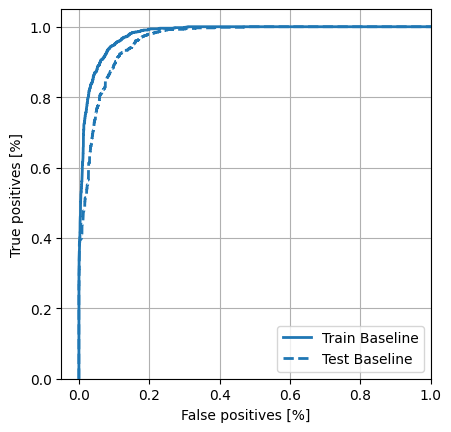

In [ ]:
train_predictions_baseline = trained_model.predict_proba(features[trainInd,:])
test_predictions_baseline = trained_model.predict_proba(features[testInd,:])
plot_roc("Train Baseline", y_train, train_predictions_baseline[:,1])
plot_roc("Test Baseline", y_test, test_predictions_baseline[:,1], color=colors[0], linestyle='--')
plt.legend(loc='lower right');

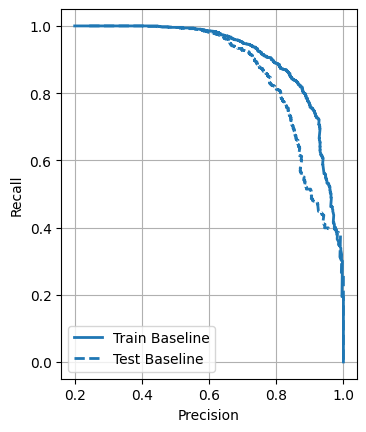

In [ ]:
plot_prc("Train Baseline", y_train, train_predictions_baseline[:,1], color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline[:,1], color=colors[0], linestyle='--')
plt.legend(loc='lower left');

True Negatives:  3558
False Positives:  241
False Negatives:  231
True Positives:  992


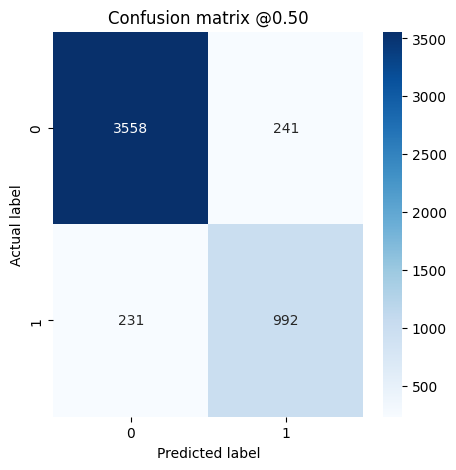

In [ ]:
plot_cm(y_test, test_predictions_baseline[:,1], p=0.5)

In [ ]:
'''TASK 4: Optimize the threshold and plot the confusion matrix (train and test)'''
#Consider using: prcThreshold() or eerThreshold()
prc_Threshold=prcThreshold(y_train, train_predictions_baseline[:,1])
eer_Threshold=eerThreshold(y_train, train_predictions_baseline[:,1])
#plot_cm(y_test, test_predictions_baseline[:,1], p=prc_Threshold)
#plot_cm(y_test, test_predictions_baseline[:,1], p=eer_Threshold)

Best prcThreshold=0.712065, F-Score=0.850
Best EER Threshold=0.582810, Roc_AUC=0.980


In [ ]:
'''Test performance'''
print('\nTRAIN')
res_ml_train=predictAndMetrics(trained_model,features[trainInd,:],y[trainInd,:],threshold=prc_Threshold)
print('\nTEST')
res_ml_test=predictAndMetrics(trained_model,features[testInd,:],y[testInd,:],threshold=prc_Threshold)


TRAIN
Y-shape  (5781, 1)
decision_threshold : 0.712065


[[4419  204]
 [ 152 1006]]
 
Balanced accuracy:  0.9123060076952476
sensitivity:  0.8687392055267703
specificity:  0.9558728098637248
precision:  0.8314049586776859
F1-score:  0.8496621621621622
AUC:  0.9798915051535146
AUC-PR:  0.9266027182605624

TEST
Y-shape  (5022, 1)
decision_threshold : 0.712065


[[3675  124]
 [ 426  797]]
 
Balanced accuracy:  0.8095180187926547
sensitivity:  0.651676206050695
specificity:  0.9673598315346144
precision:  0.8653637350705755
F1-score:  0.7434701492537313
AUC:  0.9629194066433543
AUC-PR:  0.8917711767921003


### FEATURE SELECTION AND PIPELINE

In [ ]:
features[testInd,:].shape

(5022, 36)

In [ ]:
'''TASK 5: Train an ensemble model with feature selection (e.g., Chi-square + Random forest) '''
#Consider using: using SelectKBest (f_classif) and "Pipeline" to avoid data leakage

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline

classifier =  RandomForestClassifier(n_estimators=10, max_depth=5, max_features=5, class_weight="balanced")
ml_model = Pipeline([('skb', SelectKBest(f_classif, k = 20)), ('clf', classifier)])

#Train and evaluate the model
trained_model, test_accuracy = trainModel_ML(ml_model, features[trainInd,:],y[trainInd,:].ravel(),features[testInd,:],y[testInd,:].ravel())
print(trained_model)
print(f'Test Accuracy : {test_accuracy:3f}')

Predictions shape (5022,)
Pipeline(steps=[('skb', SelectKBest(k=20)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        max_features=5, n_estimators=10))])
Test Accuracy : 0.912386


In [ ]:
'''Test performance'''
print('\nTRAIN')
res_ml_train=predictAndMetrics(trained_model,features[trainInd,:],y[trainInd,:],threshold=0.5)
print('\nTEST')
res_ml_test=predictAndMetrics(trained_model,features[testInd,:],y[testInd,:],threshold=0.5)


TRAIN
Y-shape  (5781, 1)
decision_threshold : 0.500000


[[4118  505]
 [  58 1100]]
 
Balanced accuracy:  0.9203386088256622
sensitivity:  0.9499136442141624
specificity:  0.8907635734371621
precision:  0.6853582554517134
F1-score:  0.7962359753890699
AUC:  0.9680534961297739
AUC-PR:  0.8564955427661151

TEST
Y-shape  (5022, 1)
decision_threshold : 0.500000


[[3534  265]
 [ 175 1048]]
 
Balanced accuracy:  0.8935770204191532
sensitivity:  0.856909239574816
specificity:  0.9302448012634904
precision:  0.7981721249047982
F1-score:  0.8264984227129337
AUC:  0.9682974841466435
AUC-PR:  0.9019141161126164
